In [1]:
import tensorflow as tf
tf.keras.backend.clear_session()

2025-05-21 12:39:08.853458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747831149.041022      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747831149.096668      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
path = glob.glob('/kaggle/input/indian-vehicle-dataset/State-wise_OLX/**/*.jpg', recursive=True)
print(len(path))

602


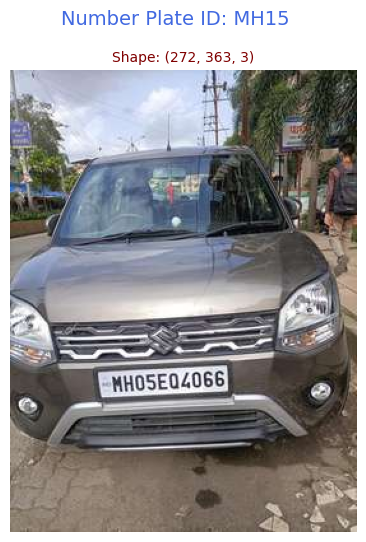

In [4]:
# Randomly choose an image path from your list
random_path = np.random.choice(path)

# Extract the image ID (filename without extension)
image_id = random_path.split("/")[-1].rsplit(".", 1)[0]

# Open and show the image
image = Image.open(random_path)
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')
plt.suptitle(f'Number Plate ID: {image_id}', color='royalblue', fontsize=14)
plt.title(f'Shape: {image.size + (3,)}', color='maroon', fontsize=10)
plt.show()


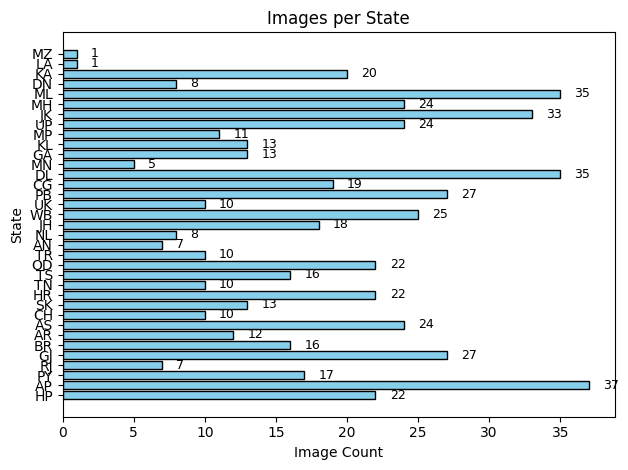

In [5]:
# Initialize an empty dictionary for counting
class_counts = {}

# Count images per class (state folder)
for p in path:
    state = p.split("/")[-2]  # Extract state name from the path
    if state in class_counts:
        class_counts[state] += 1
    else:
        class_counts[state] = 1

# Plotting the horizontal bar graph with wider bars
plt.barh(list(class_counts.keys()), list(class_counts.values()), color='skyblue', edgecolor='black', height=0.8)

# Adding frequency next to each bar
for index, value in enumerate(class_counts.values()):
    plt.text(value + 1, index, str(value), va='center', fontsize=9)

plt.ylabel('State')
plt.xlabel('Image Count')
plt.title('Images per State')
plt.tight_layout()
plt.show()

In [6]:
# Directory to store augmented data in Kaggle's working directory
aug = "/kaggle/working/aug_data"
os.makedirs(aug, exist_ok=True)

In [7]:
# ImageDataGenerator setup
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [8]:
original_data_folder = "/kaggle/input/indian-vehicle-dataset/State-wise_OLX/"
aug_data_folder = "/kaggle/working/aug_data"



In [9]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil


# Loop through each class folder
for class_folder in os.listdir(original_data_folder):
    class_path = os.path.join(original_data_folder, class_folder)
    aug_class_path = os.path.join(aug_data_folder, class_folder)
    os.makedirs(aug_class_path, exist_ok=True)

    if not os.path.isdir(class_path):
        continue

    # Copy original images to the augmented folder
    for img_name in os.listdir(class_path):
        try:
            shutil.copy(os.path.join(class_path, img_name), os.path.join(aug_class_path, img_name))
        except:
            continue

    # Generate 100 augmented images for this class
    path = os.listdir(class_path)
    img_cycle = iter(path)
    aug_count = 0

    while aug_count < 1000:
        try:
            img_name = next(img_cycle)
        except StopIteration:
            img_cycle = iter(path)
            img_name = next(img_cycle)

        try:
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path).convert("RGB")
            img_array = np.expand_dims(np.array(img), 0)

            aug_iter = datagen.flow(img_array, batch_size=1)
            aug_img = next(aug_iter)[0].astype(np.uint8)

            aug_pil = Image.fromarray(aug_img)
            aug_pil.save(os.path.join(aug_class_path, f"{img_name.split('.')[0]}_extra{aug_count}.jpg"))

            aug_count += 1
        except:
            continue

print("✅ 100 augmented images generated per class in `aug_data`.")


✅ 100 augmented images generated per class in `aug_data`.


In [10]:
path_new = glob.glob('/kaggle/working/aug_data/**/*.jpg', recursive=True)
print(len(path_new))

35602


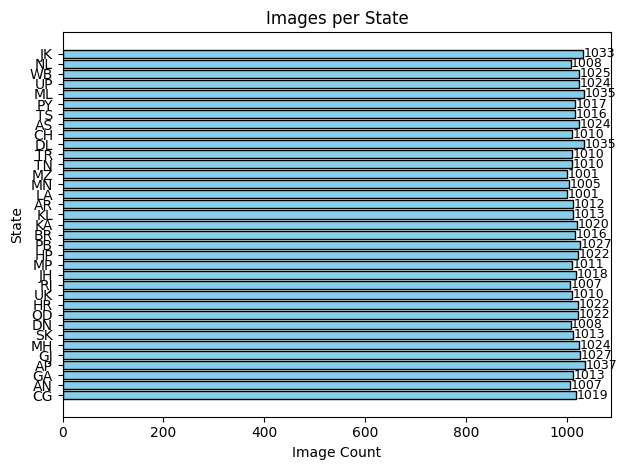

In [11]:
# Initialize an empty dictionary for counting
class_counts = {}

# Count images per class (state folder)
for p in path_new:
    state = p.split("/")[-2]  # Extract state name from the path
    if state in class_counts:
        class_counts[state] += 1
    else:
        class_counts[state] = 1

# Plotting the horizontal bar graph with wider bars
plt.barh(list(class_counts.keys()), list(class_counts.values()), color='skyblue', edgecolor='black', height=0.8)

# Adding frequency next to each bar
for index, value in enumerate(class_counts.values()):
    plt.text(value + 1, index, str(value), va='center', fontsize=9)

plt.ylabel('State')
plt.xlabel('Image Count')
plt.title('Images per State')
plt.tight_layout()
plt.show()

In [12]:
from PIL import Image
import os

for img_path in path_new:
    try:
        img = Image.open(img_path)

        # Convert to grayscale
        img = img.convert("L")

        # Resize to 128x128
        img = img.resize((128, 128))

        # Save the updated image
        img.save(img_path)  # This will overwrite the original image; adjust if needed

    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        continue


In [13]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths to your dataset
dataset_path = "/kaggle/working/aug_data"

# Class names (folder names) in your dataset
class_names = os.listdir(dataset_path)

# Create lists for image paths and labels
image_paths = []
labels = []

# Iterate through each class folder and get image paths and labels
for class_name in class_names:
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        for image_name in os.listdir(class_folder):
            image_paths.append(os.path.join(class_folder, image_name))
            labels.append(class_name)

# Split the data into training and testing sets (80% train, 20% test)
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Check the split
print(f"Total images: {len(image_paths)}")
print(f"Training set: {len(train_paths)}")
print(f"Test set: {len(test_paths)}")


Total images: 36205
Training set: 28964
Test set: 7241


In [14]:
# Directories for train and test data
train_dir = '/kaggle/working/train_data'
test_dir = '/kaggle/working/test_data'

# Create the directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Create subdirectories for each class in train and test directories
for class_name in class_names:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)


In [15]:
# Move images to their respective directories
for path, label in zip(train_paths, train_labels):
    shutil.copy(path, os.path.join(train_dir, label, os.path.basename(path)))

for path, label in zip(test_paths, test_labels):
    shutil.copy(path, os.path.join(test_dir, label, os.path.basename(path)))

print("Data split and copied to respective directories.")

Data split and copied to respective directories.


In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import numpy as np
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# ---------------------------
# Data Preprocessing
# ---------------------------
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    '/kaggle/working/train_data',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    '/kaggle/working/test_data',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Needed for accurate prediction and evaluation
)

# ---------------------------
# Class Labels and Weights
# ---------------------------
class_names = list(train_generator.class_indices.keys())
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))

# ---------------------------
# ResNet50 Model Definition
# ---------------------------
def create_resnet50(input_shape=(128, 128, 3), num_classes=len(class_names)):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

# ---------------------------
# Compile Model
# ---------------------------
model = create_resnet50()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ---------------------------
# Callbacks
# ---------------------------
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# ---------------------------
# Train Model
# ---------------------------
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    class_weight=class_weight_dict,
    callbacks=[checkpoint, reduce_lr, early_stopping]
)

# ---------------------------
# Evaluation
# ---------------------------
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred_classes, target_names=class_names))


Found 28483 images belonging to 35 classes.
Found 7119 images belonging to 35 classes.


I0000 00:00:1747832410.629050      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1747832461.772929     117 service.cc:148] XLA service 0x799e6c002fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747832461.773681     117 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747832466.308855     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/891 ━━━━━━━━━━━━━━━━━━━━ 1:13 82ms/step - accuracy: 0.0469 - loss: 4.5169   

I0000 00:00:1747832483.577380     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


891/891 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.1200 - loss: 3.4305
Epoch 1: val_loss improved from inf to 8.24757, saving model to best_model.h5
891/891 ━━━━━━━━━━━━━━━━━━━━ 239s 190ms/step - accuracy: 0.1201 - loss: 3.4301 - val_accuracy: 0.0365 - val_loss: 8.2476 - learning_rate: 0.0010
Epoch 2/20
891/891 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.4356 - loss: 2.0087
Epoch 2: val_loss improved from 8.24757 to 2.81069, saving model to best_model.h5
891/891 ━━━━━━━━━━━━━━━━━━━━ 143s 161ms/step - accuracy: 0.4357 - loss: 2.0084 - val_accuracy: 0.2892 - val_loss: 2.8107 - learning_rate: 0.0010
Epoch 3/20
891/891 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6641 - loss: 1.1333
Epoch 3: val_loss improved from 2.81069 to 1.23492, saving model to best_model.h5
891/891 ━━━━━━━━━━━━━━━━━━━━ 143s 161ms/step - accuracy: 0.6642 - loss: 1.1331 - val_accuracy: 0.6561 - val_loss: 1.2349 - learning_rate: 0.0010
Epoch 4/20
891/891 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.81

In [17]:
# For downloading the best model saved as .h5
from IPython.display import FileLink, display

# Display a download link for the .h5 model
display(FileLink('best_model.h5'))


/kaggle/working/best_model.h5

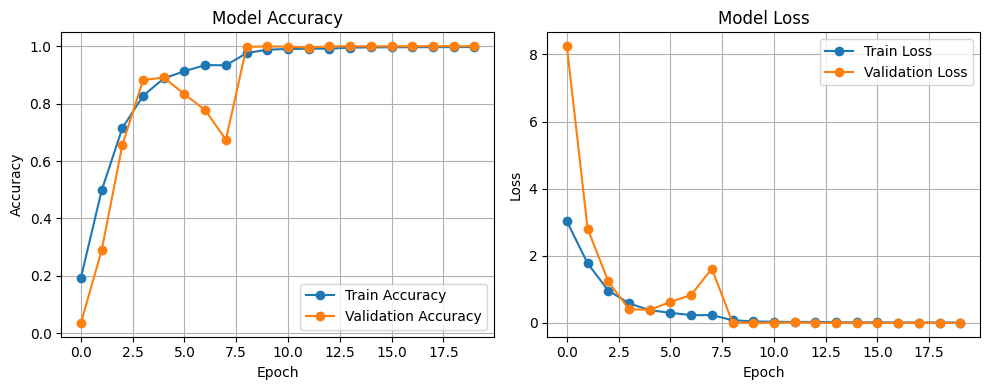

In [18]:
# ---------------------------
# Plot Accuracy and Loss Graphs
# ---------------------------
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


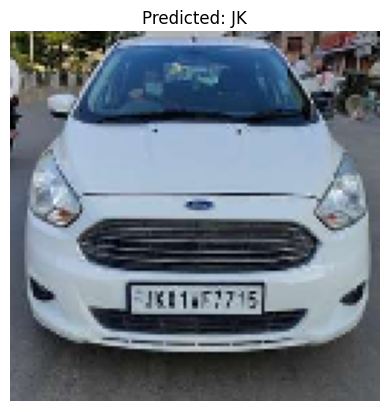

Prediction probabilities: {'AN': 1.6782744e-13, 'AP': 4.8028716e-11, 'AR': 6.3921066e-16, 'AS': 1.0013773e-09, 'BR': 2.3213955e-12, 'CG': 3.9078153e-14, 'CH': 3.8790247e-14, 'DL': 3.9470532e-10, 'DN': 3.831529e-18, 'GA': 4.771511e-17, 'GJ': 4.5649426e-15, 'HP': 2.4120296e-11, 'HR': 6.8835236e-11, 'JH': 6.161104e-12, 'JK': 1.0, 'KA': 2.7656795e-11, 'KL': 1.3014473e-12, 'LA': 9.932373e-11, 'MH': 1.2133732e-13, 'ML': 1.880803e-11, 'MN': 2.226282e-19, 'MP': 7.126026e-13, 'MZ': 2.4600804e-19, 'NL': 8.280173e-17, 'OD': 8.340768e-14, 'PB': 6.98874e-10, 'PY': 5.3994063e-11, 'RJ': 1.6757305e-14, 'SK': 5.681659e-16, 'TN': 9.05792e-16, 'TR': 2.330612e-14, 'TS': 1.208597e-16, 'UK': 8.7969604e-11, 'UP': 1.6560436e-10, 'WB': 1.1325818e-16}


'JK'

In [20]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# Predict class for a single image and display it
def predict_image_class(img_path, model, class_names, target_size=(128, 128)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    # Show image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}")
    plt.show()

    print(f"Prediction probabilities: {dict(zip(class_names, prediction[0]))}")
    return predicted_class

# Example usage:
# Replace with actual path to test image
img_path = '/kaggle/input/indian-vehicle-dataset/State-wise_OLX/JK/JK13.jpg'
predict_image_class(img_path, model, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


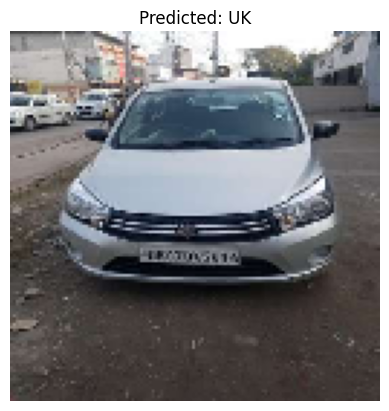

Prediction probabilities: {'AN': 7.309655e-13, 'AP': 1.6664181e-06, 'AR': 2.9323383e-15, 'AS': 4.2201218e-14, 'BR': 1.625115e-08, 'CG': 2.253049e-12, 'CH': 1.8246002e-18, 'DL': 9.164848e-09, 'DN': 6.8342403e-16, 'GA': 9.4381473e-17, 'GJ': 1.4889143e-14, 'HP': 8.315588e-15, 'HR': 1.6368785e-10, 'JH': 1.0005335e-13, 'JK': 4.41859e-12, 'KA': 7.2279923e-14, 'KL': 2.0272456e-16, 'LA': 1.1284086e-18, 'MH': 4.486747e-14, 'ML': 1.5916535e-15, 'MN': 4.3769216e-18, 'MP': 1.5595223e-16, 'MZ': 9.220313e-19, 'NL': 3.4036765e-14, 'OD': 5.398745e-16, 'PB': 3.0254186e-09, 'PY': 3.9854847e-10, 'RJ': 1.3707892e-14, 'SK': 1.5850451e-20, 'TN': 5.0481684e-13, 'TR': 5.8747264e-21, 'TS': 3.8331534e-14, 'UK': 0.99999833, 'UP': 9.806422e-15, 'WB': 1.1059023e-13}


'UK'

In [49]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# Predict class for a single image and display it
def predict_image_class(img_path, model, class_names, target_size=(128, 128)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    # Show image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}")
    plt.show()

    print(f"Prediction probabilities: {dict(zip(class_names, prediction[0]))}")
    return predicted_class

# Example usage:
# Replace with actual path to test image
img_path = '/kaggle/input/indian-vehicle-dataset/State-wise_OLX/UK/UK8.jpg'
predict_image_class(img_path, model, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


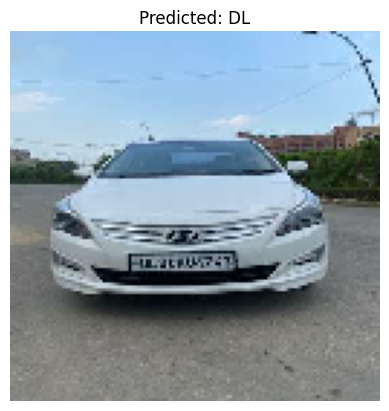

Prediction probabilities: {'AN': 2.1535131e-09, 'AP': 2.627471e-05, 'AR': 2.3193562e-11, 'AS': 4.0144982e-06, 'BR': 2.4875376e-07, 'CG': 6.84609e-07, 'CH': 6.055041e-09, 'DL': 0.9792284, 'DN': 7.1995243e-10, 'GA': 4.4886836e-09, 'GJ': 0.00049037184, 'HP': 1.2285417e-07, 'HR': 7.737554e-07, 'JH': 8.176492e-07, 'JK': 4.108569e-07, 'KA': 7.9732405e-07, 'KL': 1.134482e-09, 'LA': 1.6853227e-12, 'MH': 6.7937165e-08, 'ML': 2.4872493e-06, 'MN': 4.713067e-11, 'MP': 3.901966e-06, 'MZ': 2.2509812e-09, 'NL': 1.8680191e-10, 'OD': 0.019978782, 'PB': 0.00025905442, 'PY': 2.058865e-07, 'RJ': 1.3830272e-10, 'SK': 6.6159446e-11, 'TN': 5.9293643e-07, 'TR': 5.663525e-12, 'TS': 1.1230109e-06, 'UK': 1.8091672e-08, 'UP': 7.939467e-07, 'WB': 2.5210036e-09}


'DL'

In [50]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# Predict class for a single image and display it
def predict_image_class(img_path, model, class_names, target_size=(128, 128)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    # Show image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}")
    plt.show()

    print(f"Prediction probabilities: {dict(zip(class_names, prediction[0]))}")
    return predicted_class

# Example usage:
# Replace with actual path to test image
img_path = '/kaggle/input/indian-vehicle-dataset/State-wise_OLX/DL/DL14.jpg'
predict_image_class(img_path, model, class_names)
